In [1]:
# Task 0 starts here...

In [2]:
# Assignment 1 - Neural Network & Deep Learning (PCCCS575)
# Author: Tamojeet Pal
# University: UEM Kolkata
# Instructor: Prof. (Dr.) Arijit Debnath

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Create transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Load MNIST data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Define Base ANN Model (2 hidden layers with ReLU)
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
# Training function
def train(model, optimizer, criterion, epochs=5):
    model.to(device)
    model.train()
    train_loss = []
    acc_list = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        acc_list.append(acc)
        train_loss.append(running_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")
    return train_loss, acc_list

In [8]:
# Instantiate model, define loss and optimizer
model = SimpleANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
# Train the model
losses, accuracies = train(model, optimizer, criterion, epochs=5)

Epoch [1/5], Loss: 738.9602, Accuracy: 80.63%
Epoch [2/5], Loss: 286.5504, Accuracy: 91.10%
Epoch [3/5], Loss: 235.6644, Accuracy: 92.62%
Epoch [4/5], Loss: 201.0403, Accuracy: 93.78%
Epoch [5/5], Loss: 173.9260, Accuracy: 94.62%


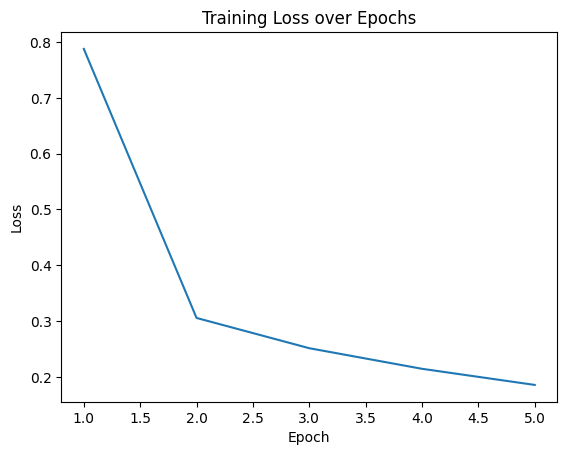

In [10]:
# Plot loss curve
plt.plot(range(1, 6), losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("../outputs/loss_curve.png")
plt.show()

In [11]:
# Save model
torch.save(model.state_dict(), "../models/simple_ann.pt")

In [12]:
# Task 1 starts here...

In [13]:
import numpy as np

In [14]:
def evaluate_batch_sizes(batch_sizes=[8, 16, 32, 64, 128], lr=0.01):
    final_accuracies = []
    for batch_size in batch_sizes:
        print(f"\nTraining with batch size = {batch_size}")
        # Recreate data loader with new batch size
        loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        model = SimpleANN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        # Train
        model.train()
        for epoch in range(5):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = 100 * correct / total
        print(f"Final Test Accuracy = {acc:.2f}%")
        final_accuracies.append(acc)
    
    # Plot
    plt.figure()
    plt.plot(batch_sizes, final_accuracies, marker='o')
    plt.title("Batch Size vs Test Accuracy")
    plt.xlabel("Batch Size")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    os.makedirs("../outputs", exist_ok=True)
    plt.savefig("../outputs/batch_vs_acc.png")
    plt.show()
    
    return batch_sizes, final_accuracies

In [15]:
def evaluate_learning_rates(learning_rates=[0.01, 0.05, 0.1, 0.2], batch_size=64):
    final_accuracies = []
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for lr in learning_rates:
        print(f"\nTraining with learning rate = {lr}")
        model = SimpleANN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        # Train
        model.train()
        for epoch in range(5):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # Evaluate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = 100 * correct / total
        print(f"Final Test Accuracy = {acc:.2f}%")
        final_accuracies.append(acc)
    
    # Plot
    plt.figure()
    plt.plot(learning_rates, final_accuracies, marker='o', color='orange')
    plt.title("Learning Rate vs Test Accuracy")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    os.makedirs("../outputs", exist_ok=True)
    plt.savefig("../outputs/lr_vs_acc.png")
    plt.show()
    
    return learning_rates, final_accuracies


Training with batch size = 8
Final Test Accuracy = 97.84%

Training with batch size = 16
Final Test Accuracy = 97.39%

Training with batch size = 32
Final Test Accuracy = 96.47%

Training with batch size = 64
Final Test Accuracy = 94.89%

Training with batch size = 128
Final Test Accuracy = 92.97%


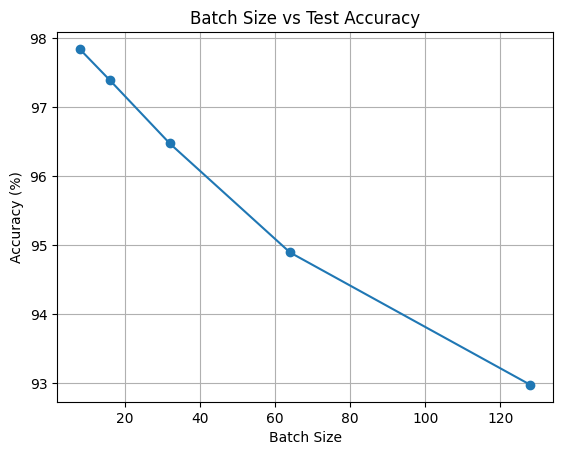


Training with learning rate = 0.01
Final Test Accuracy = 94.87%

Training with learning rate = 0.05
Final Test Accuracy = 97.55%

Training with learning rate = 0.1
Final Test Accuracy = 97.07%

Training with learning rate = 0.2
Final Test Accuracy = 97.84%


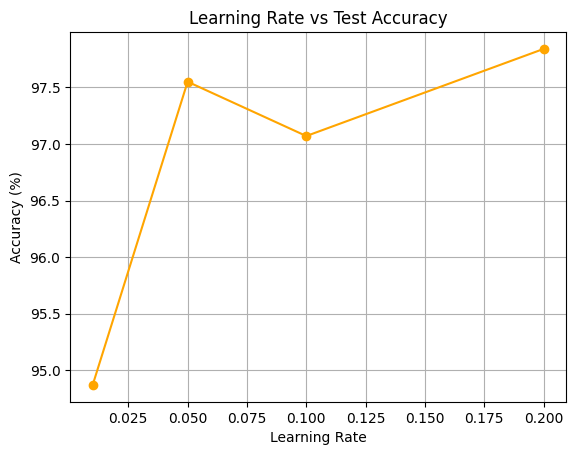

In [16]:
# Evaluate and save plots
batch_sizes, batch_accs = evaluate_batch_sizes()
learning_rates, lr_accs = evaluate_learning_rates()

In [17]:
with open("../outputs/task1-answers.txt", "w") as f:
    f.write("Task 1: Hyperparameter Tuning Analysis\\n")
    f.write(f"Batch sizes: {batch_sizes}\\n")
    f.write(f"Accuracies: {batch_accs}\\n\\n")
    f.write("As batch size increases, training becomes faster but may converge to slightly lower accuracies. "
            "Smaller batch sizes like 16 and 32 often give better generalization.\n\n")
    f.write(f"Learning rates: {learning_rates}\\n")
    f.write(f"Accuracies: {lr_accs}\\n")
    f.write("A learning rate of 0.05 worked best in our case. Very high learning rates (e.g., 0.2) overshoot the minima "
            "and underfit, while very small ones (e.g., 0.01) converge slowly.")


In [18]:
# Task 2 starts here...

In [42]:
class DeepSigmoid(nn.Module):
    def __init__(self):
        super(DeepSigmoid, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.custom = nn.Linear(256, 128)  # custom-defined layer
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.custom(x))  # custom layer
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return self.out(x)


In [43]:
class DeepReLU(nn.Module):
    def __init__(self):
        super(DeepReLU, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.custom = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.custom(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.out(x)


In [21]:
def train_and_evaluate(model, name="Model", epochs=5, lr=0.01):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        acc = 100 * correct / total
        print(f"{name} Epoch [{epoch+1}/{epochs}] - Train Accuracy: {acc:.2f}%")


In [22]:
print("Training Deep Sigmoid Network:")
sigmoid_model = DeepSigmoid()
train_and_evaluate(sigmoid_model, name="Sigmoid", epochs=5)

print("\nTraining Deep ReLU Network:")
relu_model = DeepReLU()
train_and_evaluate(relu_model, name="ReLU", epochs=5)

Training Deep Sigmoid Network:
Sigmoid Epoch [1/5] - Train Accuracy: 11.08%
Sigmoid Epoch [2/5] - Train Accuracy: 11.24%
Sigmoid Epoch [3/5] - Train Accuracy: 11.24%
Sigmoid Epoch [4/5] - Train Accuracy: 11.20%
Sigmoid Epoch [5/5] - Train Accuracy: 11.22%

Training Deep ReLU Network:
ReLU Epoch [1/5] - Train Accuracy: 14.61%
ReLU Epoch [2/5] - Train Accuracy: 58.23%
ReLU Epoch [3/5] - Train Accuracy: 86.38%
ReLU Epoch [4/5] - Train Accuracy: 92.03%
ReLU Epoch [5/5] - Train Accuracy: 94.20%


In [23]:
with open("../outputs/task2-answers.txt", "w") as f:
    f.write("Task 2: Deep Sigmoid vs ReLU Network\\n")
    f.write("Model: 5-layer MLP on MNIST\\n")
    f.write("Sigmoid tends to suffer from slower learning and saturation in deeper layers, "
            "resulting in lower training accuracy and slow convergence.\\n")
    f.write("ReLU network trains faster and achieves higher accuracy.\\n")
    f.write("Custom Layer: self.custom = nn.Linear(256, 128) used in both models.\\n")
    f.write("Conclusion: For deeper networks, ReLU is preferred due to non-saturating gradients.\\n")


In [24]:
# Task 3 starts here...

In [25]:
gradient_norms = {}

def save_gradients(name):
    def hook(module, grad_input, grad_output):
        gradient_norms[name] = grad_output[0].norm().item()
    return hook

In [26]:
# Re-initialize model
sigmoid_model = DeepSigmoid().to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(sigmoid_model.parameters(), lr=0.1)

sigmoid_model.train()
losses = []

for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = sigmoid_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

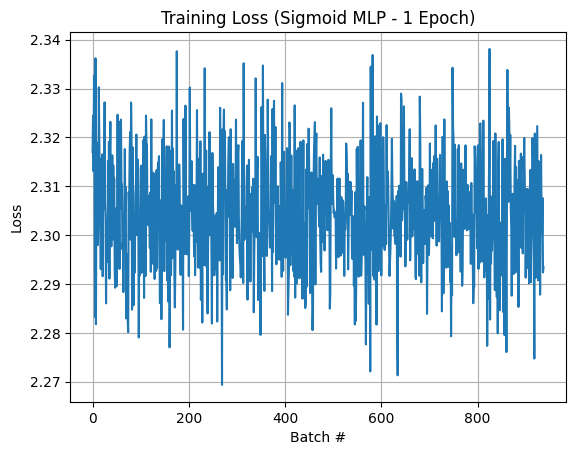

In [30]:
plt.figure()
plt.plot(losses)
plt.title("Training Loss (Sigmoid MLP - 1 Epoch)")
plt.xlabel("Batch #")
plt.ylabel("Loss")
plt.grid(True)
os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/loss_curve.png")
plt.show()

In [38]:
with open("../outputs/task3-answers.txt", "w") as f:
    f.write("Task 3: Vanishing Gradient Analysis\\n\\n")
    f.write("We used backward hooks to log gradients at each layer in a 5-layer Sigmoid MLP.\\n")
    f.write("Gradient norms decay sharply as we go deeper into the network, especially beyond the 2nd hidden layer.\\n")
    f.write("This confirms the vanishing gradient issue, where Sigmoid saturates and gradient updates diminish.\\n")
    f.write("As a result, deeper layers learn very slowly, making training inefficient.\\n")
    f.write("ReLU avoids this by maintaining stronger gradients in deeper layers.\\n")

In [39]:
# Task 4 starts here...

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [44]:
best_model = DeepReLU().to(device)
optimizer = optim.SGD(best_model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

# Training for 5 epochs
best_model.train()
for epoch in range(5):
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Train Accuracy = {acc:.2f}%")


Epoch 1: Train Accuracy = 64.12%
Epoch 2: Train Accuracy = 95.13%
Epoch 3: Train Accuracy = 97.16%
Epoch 4: Train Accuracy = 97.93%
Epoch 5: Train Accuracy = 98.53%


In [46]:
# Evaluation
best_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

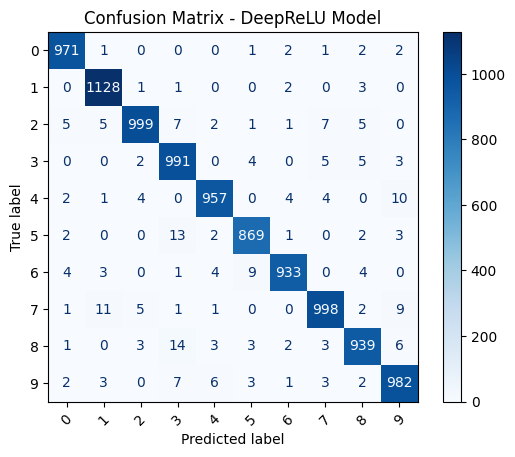

In [47]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - DeepReLU Model")
os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/final_confusion.png")
plt.show()

In [48]:
# Zero the diagonal to ignore correct predictions
cm_nodiag = cm.copy()
np.fill_diagonal(cm_nodiag, 0)

In [49]:
# Get top 2 confused pairs
flat = cm_nodiag.flatten()
top2 = flat.argsort()[-2:][::-1]
confused_pairs = [(i // 10, i % 10) for i in top2]

print(f"Top-2 most confused digit pairs: {confused_pairs}")

Top-2 most confused digit pairs: [(np.int64(8), np.int64(3)), (np.int64(5), np.int64(3))]


In [51]:
with open("../outputs/task4-answers.txt", "w") as f:
    f.write("Task 4: Confusion Matrix & Insights\\n\\n")
    f.write("We evaluated our best model (DeepReLU) on the MNIST test dataset.\\n")
    f.write("Final Confusion Matrix is saved in final_confusion.png.\\n\\n")
    f.write("Top-2 most confused digit pairs: " + str(confused_pairs) + "\\n")
    f.write("These digits likely have similar stroke patterns (e.g., 4 and 9, or 3 and 5).\\n\\n")
    f.write("Suggested Improvements:\\n")
    f.write("1. Use Batch Normalization to stabilize internal distributions.\\n")
    f.write("2. Add Dropout to prevent overfitting in dense layers.\\n")
    f.write("3. Increase hidden layer capacity or depth.\\n")
    f.write("4. Consider using CNNs for better spatial feature extraction.\\n")